<a href="https://colab.research.google.com/github/abrahama976/CNN_LSTM_Production_LightWeight/blob/main/CNN_LSTM_Production_LightWeight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN–LSTM with Attention for Production Progress Prediction

This notebook implements an improved **CNN–LSTM with multi-head attention** model
for **production progress prediction** in an IIoT-enabled manufacturing context.

We compare and align with the approach in:

> Liu et al. (2023) – *A transfer learning CNN-LSTM network-based production progress prediction approach in IIoT-enabled manufacturing.*

## Goals

- Use the **same baseline dataset** (`X_hist_train.npy`, `X_hist_val.npy`, `X_curr_train.npy`, `X_curr_val.npy`) that was used to validate the Liu2023 baseline model.
- Make it explicit that this **baseline dataset is synthetic**, generated by a realistic manufacturing simulator to match the **structure and feature types** described in the paper.
- Evaluate a **compact (~1.0M parameters)** CNN–Attention–LSTM model on this baseline dataset.
- Allow an optional **PCA preprocessing step** to be turned ON/OFF with a single flag.
- Provide clean, reproducible **training, evaluation, and logging** suitable for thesis/reporting.

**Default:** This notebook runs on the **baseline synthetic dataset** with **PCA turned OFF**.

## Step 0: Environment Setup & Imports

In [1]:
import os
import random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Reshape, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    LSTM, Dense, Dropout, BatchNormalization, TimeDistributed,
    MultiHeadAttention, Add, LayerNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Pretty printing for numpy
np.set_printoptions(precision=4, suppress=True)

print("TensorFlow version:", tf.__version__)

# Detect if we are in Colab (for Google Drive mounting)
try:
    import google.colab  # type: ignore
    COLAB_ENV = True
    print("Running in Google Colab environment.")
except ImportError:
    COLAB_ENV = False
    print("Not running in Google Colab.")

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# GPU info
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ GPU detected:", gpus)
else:
    print("⚠️ No GPU detected - training will be slower.")

TensorFlow version: 2.19.0
Running in Google Colab environment.
✅ GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Step 1. Configuration: Choose Data Source

In [2]:
# ⚙️ GLOBAL CONFIG
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# DATA_MODE controls which dataset is used:
# - 'baseline'  : load baseline .npy files from Google Drive

DATA_MODE = "baseline"          # Default: use the baseline dataset

# PCA toggle:
USE_PCA   = False               # ← TURN PCA ON/OFF HERE
PCA_VAR   = 0.92                # Used only if USE_PCA=True (variance retained)

# Baseline data path (Liu2023-style dataset)
BASELINE_DATA_PATH = "/content/drive/MyDrive/Colab_Data/Production_Prediction/"

# Synthetic data config (for future experiments; not required to use now)
SYNTH_N_ORDERS         = 50
SYNTH_STEPS_PER_ORDER  = 200
SYNTH_SEED             = 42

print(f"DATA_MODE = {DATA_MODE}")
print(f"USE_PCA   = {USE_PCA}")
if DATA_MODE == "baseline":
    print(f"Baseline path: {BASELINE_DATA_PATH}")

DATA_MODE = baseline
USE_PCA   = True
Baseline path: /content/drive/MyDrive/Colab_Data/Production_Prediction/


## 3. Custom R² Metric

In [3]:
class R2Score(tf.keras.metrics.Metric):
    """Custom Keras metric for R² (coefficient of determination)."""

    def __init__(self, name="r2", **kwargs):
        super().__init__(name=name, **kwargs)
        self.ssr = self.add_weight(name='ssr', initializer='zeros')
        self.sst = self.add_weight(name='sst', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        y_true_mean = tf.reduce_mean(y_true)

        ssr = tf.reduce_sum(tf.square(y_true - y_pred))
        sst = tf.reduce_sum(tf.square(y_true - y_true_mean))

        self.ssr.assign_add(ssr)
        self.sst.assign_add(sst)

    def result(self):
        return 1.0 - (self.ssr / (self.sst + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.ssr.assign(0.0)
        self.sst.assign(0.0)

## Step 3:  Manufacturing Configuration & Synthetic Data Generator (Extra - optional)

In [ ]:
print("\n STEP 3: MANUFACTURING CONFIGURATION (for synthetic data)")
print("=" * 80)

MACHINE_CONFIG = {
    'M1': {'type': 'Lathe_A',   'capacity': 60, 'precision': 0.98},
    'M2': {'type': 'Lathe_B',   'capacity': 55, 'precision': 0.97},
    'M3': {'type': 'Mill_A',    'capacity': 50, 'precision': 0.96},
    'M4': {'type': 'Mill_B',    'capacity': 45, 'precision': 0.95},
    'M5': {'type': 'Drill_A',   'capacity': 70, 'precision': 0.94},
    'M6': {'type': 'Drill_B',   'capacity': 65, 'precision': 0.93},
    'M7': {'type': 'Grinder_A', 'capacity': 40, 'precision': 0.97},
    'M8': {'type': 'Grinder_B', 'capacity': 42, 'precision': 0.96},
    'M9': {'type': 'CNC_A',     'capacity': 35, 'precision': 0.99},
    'M10': {'type': 'Polish_A', 'capacity': 80, 'precision': 0.92},
    'M11': {'type': 'Inspect_A','capacity': 90, 'precision': 0.98},
    'M12': {'type': 'Load_Unload','capacity': 100, 'precision': 0.95},
    'M13': {'type': 'Final_Test','capacity': 40, 'precision': 0.96}
}

PRODUCT_CONFIG = {
    'Axis': {
        'complexity': 3.2, 'base_time': 45.0,
        'process_route': ['M12', 'M1', 'M4', 'M7', 'M6', 'M10', 'M11', 'M13'],
        'quality_threshold': 0.95
    },
    'Flange': {
        'complexity': 2.8, 'base_time': 35.0,
        'process_route': ['M12', 'M2', 'M3', 'M8', 'M7', 'M5', 'M6', 'M10', 'M11', 'M13'],
        'quality_threshold': 0.92
    },
    'Board': {
        'complexity': 2.1, 'base_time': 25.0,
        'process_route': ['M12', 'M9', 'M3', 'M8', 'M5', 'M6', 'M10', 'M11', 'M13'],
        'quality_threshold': 0.88
    }
}

print(f"✅ {len(MACHINE_CONFIG)} machines, {len(PRODUCT_CONFIG)} products.")
print("=" * 80)


🏭 STEP 3: MANUFACTURING CONFIGURATION (for synthetic data)
✅ 13 machines, 3 products.


Data Generator Algorithm (New - Optional)

In [ ]:
class ManufacturingDataGenerator:
    def __init__(self, seed=42):
        np.random.seed(seed)

    def generate_features(self, product_type, time_step, total_steps, order_info):
        features = {}
        progress = min(1.0, time_step / max(total_steps - 1, 1))

        route = PRODUCT_CONFIG[product_type]['process_route']
        current_step = min(int(progress * len(route)), len(route) - 1)
        current_machine = route[current_step]
        idx = 0

        # Non-linear progress relationships
        wear_acceleration = 1.0 + (progress ** 2) * 0.3

        # Progress slows near completion
        if progress > 0.8:
            effective_progress = 0.8 + (progress - 0.8) * 0.5
        else:
            effective_progress = progress

        # Checkpoint slowdowns (inspection gates)
        checkpoint_slowdown = 1.0
        if (0.23 < progress < 0.27) or (0.48 < progress < 0.52) or (0.73 < progress < 0.77):
            checkpoint_slowdown = 0.85  # 15% slowdown at checkpoints

        # 1. Machine features (13 machines × 20 features = 260)
        for mid in MACHINE_CONFIG.keys():
            mc = MACHINE_CONFIG[mid]
            active = (mid == current_machine or mid in route)

            # Equipment condition, maintenance, occasional issues
            machine_condition = np.random.uniform(0.92, 1.08)
            maintenance_status = np.random.choice(
                [0.95, 1.0, 1.0, 1.0, 1.05],
                p=[0.1, 0.3, 0.3, 0.2, 0.1]
            )
            equipment_issue = np.random.random() < 0.01
            issue_factor = np.random.uniform(0.7, 0.95) if equipment_issue else 1.0

            eff = (mc['precision'] if active else 0.1) * machine_condition * maintenance_status * issue_factor

            sensor_drift = np.random.uniform(0.95, 1.05)
            measurement_noise = np.random.normal(1.0, 0.02)

            feats = [
                1.0 if active else 0.0,                             # active flag
                mc['capacity'] * eff + np.random.normal(0, 5),      # effective capacity
                np.random.uniform(0.3, 0.9) if active else 0.1,     # utilization
                (progress * 0.8 + np.random.normal(0, 0.1)) * sensor_drift,  # tool wear
                (0.02 + progress * 0.05) * measurement_noise + np.random.normal(0, 0.02),
                (0.02 + progress * 0.05) * measurement_noise + np.random.normal(0, 0.02),
                (0.02 + progress * 0.05) * measurement_noise + np.random.normal(0, 0.02),
                25 + (15 if active else 0) + np.random.normal(0, 2), # temperature
                (100 if active else 5) + np.random.normal(0, 10),    # load/current
                int(time_step * eff),                                # processed parts
                np.random.binomial(5 if equipment_issue else 2, 0.05), # error flags
                effective_progress * 100 * checkpoint_slowdown + np.random.normal(0, 5),
                eff + np.random.normal(0, 0.02),
                mc['precision'] * eff,
                mc['capacity'] * eff,
                np.random.uniform(5, 30) if time_step < 3 else 0,
                max(0, np.random.uniform(0, 10) - eff * 10),
                min(1, eff + np.random.normal(0, 0.05)),
                np.random.poisson(0.1),
                int(time_step * eff * 10),
            ]
            for v in feats:
                features[f"f_{idx:03d}"] = v
                idx += 1

        # 2. Process features (15)
        complexity = PRODUCT_CONFIG[product_type]['complexity']
        for v in [
            complexity * 0.3 + np.random.normal(0, 0.05),
            1200 / complexity + np.random.normal(0, 20),
            np.random.uniform(0.5, 3.0), np.random.uniform(2, 8),
            np.random.uniform(50, 200),
            25 + complexity * 5 + np.random.normal(0, 2),
            np.random.uniform(100, 3000), np.random.uniform(-100, 100),
            np.random.uniform(-100, 100), np.random.uniform(0, 50),
            200 + complexity * 50 + np.random.normal(0, 10),
            np.random.uniform(0.8, 3.2), 0.01 + np.random.uniform(-0.002, 0.002),
            complexity * 50 + np.random.normal(0, 10),
            0.9 + np.random.normal(0, 0.05)
        ]:
            features[f"f_{idx:03d}"] = v
            idx += 1

        # 3. Quality features (3 products × 12 = 36)
        base_q = PRODUCT_CONFIG[product_type]['quality_threshold']
        for prod in ['Axis', 'Flange', 'Board']:
            mod = 1.0 if prod == product_type else 0.5
            for v in [
                base_q * mod + np.random.normal(0, 0.02),
                base_q * mod + np.random.normal(0, 0.03),
                0.8 + np.random.normal(0, 0.05),
                base_q * mod + np.random.normal(0, 0.04),
                base_q * 0.8 * mod + np.random.normal(0, 0.03),
                base_q * mod + np.random.normal(0, 0.02),
                base_q * mod + np.random.normal(0, 0.05),
                base_q * mod + np.random.normal(0, 0.03),
                base_q * 0.9 * mod + np.random.normal(0, 0.04),
                base_q * 0.85 * mod + np.random.normal(0, 0.03),
                1 - abs(np.random.normal(0, 0.02)),
                max(0, np.random.poisson((1 - base_q) * 5))
            ]:
                features[f"f_{idx:03d}"] = v
                idx += 1

        # 4. Environmental features (8)
        for v in [
            22 + np.random.normal(0, 3),
            45 + np.random.normal(0, 8),
            101.3 + np.random.normal(0, 0.2),
            max(0, np.random.poisson(15)),
            65 + np.random.normal(0, 5),
            500 + np.random.normal(0, 50),
            2.5 + np.random.normal(0, 0.3),
            0.01 + np.random.exponential(0.02)
        ]:
            features[f"f_{idx:03d}"] = v
            idx += 1

        # 5. Temporal features (10) – includes progress directly
        for v in [
            (time_step * 0.5) % 24,
            order_info.get('start_day', 1),
            1 if 6 <= (time_step * 0.5) % 24 <= 14 else 2,
            time_step * 0.5,
            (total_steps - time_step) * 0.5,
            PRODUCT_CONFIG[product_type]['base_time'],
            15 if time_step < 5 else 0,
            max(0, np.random.uniform(0, 10) - progress * 10),
            current_step,
            progress
        ]:
            features[f"f_{idx:03d}"] = v
            idx += 1

        # 6. Control features (25)
        for v in [
            order_info.get('batch_size', 100),
            order_info.get('lot_number', 1001),
            order_info.get('priority', 2),
            complexity,
            min(1, 1.2 - progress),
            0.95 + np.random.normal(0, 0.02),
            0.85 + np.random.normal(0, 0.05),
            hash(current_machine) % 1000 / 1000,
            max(1, 5 - int(progress * 5)),
            0.7 + np.random.normal(0, 0.1),
            1 if current_step == 3 else 0,
            95 + np.random.normal(0, 3),
            0.90 + np.random.normal(0, 0.02),
            base_q,
            150 + complexity * 50 + np.random.normal(0, 10),
            order_info.get('urgency', 0.5),
            0.75 + np.random.normal(0, 0.05),
            0.6 + np.random.normal(0, 0.1),
            (1 - progress) * 0.05,
            0.02 + np.random.exponential(0.01),
            time_step % 100 / 100,
            500 + np.random.normal(0, 50),
            0.03 + np.random.exponential(0.01),
            0.7 + np.random.normal(0, 0.1),
            0.98 + np.random.normal(0, 0.01),
        ]:
            features[f"f_{idx:03d}"] = v
            idx += 1

        # 7. Historical / residual features — fill to 948
        for _ in range(948 - idx):
            v = np.sin(time_step * 0.1 + idx * 0.01) * 0.3 + progress * 0.2 + np.random.normal(0, 0.1)
            features[f"f_{idx:03d}"] = v
            idx += 1

        # Target: progress in [0, 100]
        return features, progress * 100

    def generate_order(self, product_type, size, order_info):
        samples, targets = [], []

        # Material batch factors
        material_hardness_factor = np.random.uniform(0.95, 1.05)

        for step in range(size):
            s, p = self.generate_features(product_type, step, size, order_info)

            # Apply material factor to process features 260–274 (15 process features)
            for i in range(260, 275):
                feat_name = f"f_{i:03d}"
                if feat_name in s:
                    s[feat_name] *= material_hardness_factor

            samples.append(s)
            targets.append(p)

        X_df = pd.DataFrame(samples)
        y_df = pd.DataFrame({"progress": targets})
        return X_df, y_df

Synthetic Data Loader (Optional)

In [ ]:
def load_synthetic_raw(n_orders=50, steps_per_order=200, seed=SYNTH_SEED):
    """
    Generate synthetic manufacturing data and return raw sequences:
    X_raw (N, 10, 948), y_raw (N, 1).

    This is conceptually aligned with the baseline simulator used to
    create the .npy files, but here we generate fresh data on the fly.
    """
    print("\n📊 Synthetic data generation")
    print("=" * 80)
    print(f"Generating {n_orders} orders × {steps_per_order} steps...")

    gen = ManufacturingDataGenerator(seed=seed)
    all_X, all_y = [], []

    for i in range(n_orders):
        prod = np.random.choice(['Axis', 'Flange', 'Board'])
        info = {
            "order_id": f"O{i+1:03d}",
            "batch_size": np.random.randint(50, 200),
            "lot_number": 2000 + i,
            "priority": np.random.randint(1, 4),
            "start_day": np.random.randint(1, 8),
            "urgency": np.random.uniform(0.2, 0.8),
        }
        X_df, y_df = gen.generate_order(prod, steps_per_order, info)
        all_X.append(X_df)
        all_y.append(y_df)

    X_full = pd.concat(all_X, ignore_index=True).values.astype("float32")
    y_full = pd.concat(all_y, ignore_index=True).values.astype("float32")

    print(f"✅ Generated raw table: {X_full.shape}")
    print(f"   Progress range: [{y_full.min():.1f}, {y_full.max():.1f}]")

    # Convert to sequences of length 10 (sliding window, stride=1)
    timesteps = 10
    N_total = X_full.shape[0]
    n_seq = N_total - timesteps + 1

    X_seq = []
    y_seq = []

    for i in range(n_seq):
        X_seq.append(X_full[i:i+timesteps, :])
        # Use last progress in the window as the target
        y_seq.append(y_full[i+timesteps-1, 0])

    X_raw = np.stack(X_seq, axis=0)
    y_raw = np.array(y_seq).reshape(-1, 1)

    print(f"✅ Synthetic sequences: X_raw={X_raw.shape}, y_raw={y_raw.shape}")
    print("=" * 80)
    return X_raw, y_raw

## 5. Data Loading (Baseline) (Main)

In [4]:
def load_baseline_raw(data_path):
    """
    Load the Liu2023-style baseline dataset from .npy files and
    return raw sequences X_raw (N, 10, 948), y_raw (N, 1).

    Note:
    - This dataset is **synthetic**, generated by a manufacturing simulator
      designed to approximate the multi-stage machining line described in Liu (2023).
    - Each sample is a sequence of 10 timesteps with 948 features, including:
      machine states, process variables, quality indicators, environmental
      variables, temporal and control parameters.
    """
    print("\n📥 Loading baseline raw data")
    print("=" * 80)

    X_hist_train = np.load(os.path.join(data_path, "X_hist_train.npy"))
    y_hist_train = np.load(os.path.join(data_path, "y_hist_train.npy"))
    X_hist_val   = np.load(os.path.join(data_path, "X_hist_val.npy"))
    y_hist_val   = np.load(os.path.join(data_path, "y_hist_val.npy"))

    X_curr_train = np.load(os.path.join(data_path, "X_curr_train.npy"))
    y_curr_train = np.load(os.path.join(data_path, "y_curr_train.npy"))
    X_curr_val   = np.load(os.path.join(data_path, "X_curr_val.npy"))
    y_curr_val   = np.load(os.path.join(data_path, "y_curr_val.npy"))

    print("✅ Loaded arrays:")
    print(f"  X_hist_train: {X_hist_train.shape}, y_hist_train: {y_hist_train.shape}")
    print(f"  X_hist_val  : {X_hist_val.shape}, y_hist_val  : {y_hist_val.shape}")
    print(f"  X_curr_train: {X_curr_train.shape}, y_curr_train: {y_curr_train.shape}")
    print(f"  X_curr_val  : {X_curr_val.shape}, y_curr_val  : {y_curr_val.shape}")

    # Sanity: each batch is (N, 10, 948)
    assert X_hist_train.shape[1:] == (10, 948)
    assert X_hist_val.shape[1:]   == (10, 948)
    assert X_curr_train.shape[1:] == (10, 948)
    assert X_curr_val.shape[1:]   == (10, 948)

    # Combine historical + current, train + val, into one pool
    X_raw = np.vstack([X_hist_train, X_hist_val, X_curr_train, X_curr_val])
    y_raw = np.vstack([y_hist_train, y_hist_val, y_curr_train, y_curr_val])

    print(f"\n📊 Combined raw dataset:")
    print(f"   X_raw: {X_raw.shape} (N, timesteps, features)")
    print(f"   y_raw: {y_raw.shape}")
    print(f"   Progress range: [{y_raw.min():.3f}, {y_raw.max():.3f}]")
    print("=" * 80)

    return X_raw.astype("float32"), y_raw.astype("float32")

**Step 5.1** Preprocessing Function with PCA Toggle

In [5]:
def preprocess_sequences(X_raw, y_raw, use_pca=True, pca_var=0.92, timesteps=10):
    """
    Shared preprocessing for baseline + synthetic data:
    - X_raw: (N, timesteps, features)
    - y_raw: (N, 1)
    - use_pca: True = StandardScaler + PCA, False = StandardScaler only

    Returns:
    X_train, X_val, y_train, y_val, scaler, pca_or_None
    """
    print("\n🔄 STEP 5: PREPROCESSING")
    print("=" * 80)

    N, T, F = X_raw.shape
    assert T == timesteps, f"Expected {timesteps} timesteps, got {T}"

    # Flatten for scaling
    X_flat = X_raw.reshape(N, T * F)

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat)
    print(f"✅ Scaled flattened features: {X_scaled.shape}")

    if use_pca:
        print("\n🔎 PCA is ON")
        pca = PCA(n_components=pca_var, random_state=SEED)
        X_pca = pca.fit_transform(X_scaled)
        variance_retained = pca.explained_variance_ratio_.sum()
        print(f"   PCA: {X_scaled.shape[1]} → {X_pca.shape[1]} components")
        print(f"   Variance retained: {variance_retained:.1%}")

        # Make feature count divisible by timesteps
        n_components = X_pca.shape[1]
        features_per_timestep = n_components // timesteps
        truncate_len = features_per_timestep * timesteps
        X_pca = X_pca[:, :truncate_len]

        print(f"   Truncate to {truncate_len} features (divisible by {timesteps})")
        X_seq = X_pca.reshape(N, timesteps, features_per_timestep)
        print(f"✅ Sequences (with PCA): {X_seq.shape}")
    else:
        print("\n🔎 PCA is OFF – using scaled raw features.")
        X_seq = X_scaled.reshape(N, timesteps, F)
        pca = None
        print(f"✅ Sequences (no PCA): {X_seq.shape}")

    # Train/val split (80/20)
    split_idx = int(0.8 * N)
    X_train, X_val = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_val = y_raw[:split_idx], y_raw[split_idx:]

    print("\n📊 Final preprocessed shapes:")
    print(f"   X_train: {X_train.shape}")
    print(f"   X_val  : {X_val.shape}")
    print(f"   y_train: {y_train.shape}")
    print(f"   y_val  : {y_val.shape}")
    print("=" * 80)

    return X_train, X_val, y_train, y_val, scaler, pca

📊 **STEP 5.2:** DATA LOADING + PREPROCESSING

In [6]:
print("\n📊 STEP 4–5: DATA LOADING + PREPROCESSING")
print("=" * 80)

# Mount Google Drive if using baseline data in Colab
if DATA_MODE == "baseline" and COLAB_ENV:
    print("📂 Mounting Google Drive for baseline data...")
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive', force_remount=True)
    print("✅ Google Drive mounted.")

# Decide which raw loader to use
if DATA_MODE == "baseline":
    print("📦 DATA MODE: baseline (synthetic, Liu2023-style .npy sequences)")
    X_raw, y_raw = load_baseline_raw(BASELINE_DATA_PATH)
elif DATA_MODE == "synthetic":
    print("📦 DATA MODE: synthetic (ManufacturingDataGenerator)")
    X_raw, y_raw = load_synthetic_raw(
        n_orders=SYNTH_N_ORDERS,
        steps_per_order=SYNTH_STEPS_PER_ORDER,
        seed=SYNTH_SEED
    )
else:
    raise ValueError(f"Unknown DATA_MODE: {DATA_MODE}")

# Shared preprocessing (PCA toggle applied here)
X_train, X_val, y_train, y_val, scaler, pca = preprocess_sequences(
    X_raw, y_raw,
    use_pca=USE_PCA,
    pca_var=PCA_VAR,
    timesteps=10
)

print("\nBasic target stats:")
print("y_train: min={:.3f}, max={:.3f}, mean={:.3f}, std={:.3f}".format(
    float(y_train.min()), float(y_train.max()), float(y_train.mean()), float(y_train.std())
))
print("y_val  : min={:.3f}, max={:.3f}, mean={:.3f}, std={:.3f}".format(
    float(y_val.min()), float(y_val.max()), float(y_val.mean()), float(y_val.std())
))

input_shape = (X_train.shape[1], X_train.shape[2])
print(f"\nFinal input shape for model: {input_shape}")
print("=" * 80)


📊 STEP 4–5: DATA LOADING + PREPROCESSING
📂 Mounting Google Drive for baseline data...
Mounted at /content/drive
✅ Google Drive mounted.
📦 DATA MODE: baseline (synthetic, Liu2023-style .npy sequences)

📥 Loading baseline raw data
✅ Loaded arrays:
  X_hist_train: (8602, 10, 948), y_hist_train: (8602, 1)
  X_hist_val  : (1519, 10, 948), y_hist_val  : (1519, 1)
  X_curr_train: (792, 10, 948), y_curr_train: (792, 1)
  X_curr_val  : (199, 10, 948), y_curr_val  : (199, 1)

📊 Combined raw dataset:
   X_raw: (11112, 10, 948) (N, timesteps, features)
   y_raw: (11112, 1)
   Progress range: [0.000, 1.000]

🔄 STEP 5: PREPROCESSING
✅ Scaled flattened features: (11112, 9480)

🔎 PCA is ON
   PCA: 9480 → 1924 components
   Variance retained: 92.0%
   Truncate to 1920 features (divisible by 10)
✅ Sequences (with PCA): (11112, 10, 192)

📊 Final preprocessed shapes:
   X_train: (8889, 10, 192)
   X_val  : (2223, 10, 192)
   y_train: (8889, 1)
   y_val  : (2223, 1)

Basic target stats:
y_train: min=0.000

## 6. Model Architecture: CNN–Attention–LSTM

In [7]:
def build_model(input_shape):
    """Build the CNN–Attention–LSTM model."""
    inputs = Input(shape=input_shape)

    # Add channel dimension for Conv1D
    x = Reshape((input_shape[0], input_shape[1], 1))(inputs)

    # TimeDistributed CNN blocks
    for filters in [48, 96, 160]:
        x = TimeDistributed(Conv1D(filters, 3, padding='same', activation='relu'))(x)
        x = TimeDistributed(BatchNormalization())(x)
        x = TimeDistributed(MaxPooling1D(2))(x)

    # Global average pooling across spatial dimension
    x = TimeDistributed(GlobalAveragePooling1D())(x)  # (None, timesteps, 160)

    # Multi-head self-attention over timesteps
    attn = MultiHeadAttention(num_heads=4, key_dim=32)(x, x, x)
    attn = Dropout(0.1)(attn)  # small dropout for stability
    x = Add()([x, attn])
    x = LayerNormalization()(x)

    # LSTM stack
    x = LSTM(320, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = LSTM(128, return_sequences=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Dense head
    x = Dense(96, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(48, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    return model

print("\n🏗️ STEP 6: MODEL ARCHITECTURE")
print("=" * 80)

model = build_model(input_shape)
model.compile(
    optimizer=Adam(2e-3),
    loss='mse',
    metrics=['mae', R2Score(name='r2')]
)
model.summary()

n_params = model.count_params()
print(f"\n✅ Model built with {n_params:,} trainable parameters.")
print("=" * 80)


🏗️ STEP 6: MODEL ARCHITECTURE


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 192)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 10, 192,   │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 10, 192,   │        192 │ reshape[0][0]     │
│ (TimeDistributed)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 10, 192,   │        192 │ time_distributed… │
│ (TimeDistributed)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 10, 96,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 10, 96,    │     13,920 │ time_distributed… │
│ (TimeDistributed)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 10, 96,    │        384 │ time_distributed… │
│ (TimeDistributed)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 10, 48,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 10, 48,    │     46,240 │ time_distributed… │
│ (TimeDistributed)   │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 10, 48,    │        640 │ time_distributed… │
│ (TimeDistributed)   │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 10, 24,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 10, 160)   │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 160)   │     82,464 │ time_distributed… │
│ (MultiHeadAttentio… │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 160)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 160)   │          0 │ time_distributed… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 160)   │        320 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 10, 320)   │    615,680 │ layer_normalizat

 Total params: 1,008,801 (3.85 MB)

 Trainable params: 1,007,297 (3.84 MB)

 Non-trainable params: 1,504 (5.88 KB)


✅ Model built with 1,008,801 trainable parameters.


## 7. Training

In [8]:
print("\n🚂 STEP 7: TRAINING")
print("=" * 80)

EPOCHS = 120
BATCH_SIZE = 32

early_stop = EarlyStopping(
    monitor='val_r2',
    mode='max',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_r2',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    mode='max',
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print(f"\n✅ Training complete ({len(history.history['loss'])} epochs).")
print("=" * 80)


🚂 STEP 7: TRAINING
Epoch 1/120
278/278 ━━━━━━━━━━━━━━━━━━━━ 37s 66ms/step - loss: 0.2951 - mae: 0.3991 - r2: -2.5732 - val_loss: 0.0611 - val_mae: 0.2025 - val_r2: 0.2337 - learning_rate: 0.0020
Epoch 2/120
278/278 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - loss: 0.0288 - mae: 0.1335 - r2: 0.6484 - val_loss: 0.3358 - val_mae: 0.5508 - val_r2: -3.2087 - learning_rate: 0.0020
Epoch 3/120
278/278 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - loss: 0.0130 - mae: 0.0894 - r2: 0.8414 - val_loss: 1.0979 - val_mae: 1.0034 - val_r2: -12.7595 - learning_rate: 0.0020
Epoch 4/120
278/278 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - loss: 0.0092 - mae: 0.0760 - r2: 0.8877 - val_loss: 0.5533 - val_mae: 0.6579 - val_r2: -5.9341 - learning_rate: 0.0020
Epoch 5/120
278/278 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - loss: 0.0078 - mae: 0.0690 - r2: 0.9049 - val_loss: 0.4418 - val_mae: 0.5749 - val_r2: -4.5373 - learning_rate: 0.0020
Epoch 6/120
278/278 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - loss: 0.0070 - mae: 0.0663 - r2: 0.9140 - 

## 8. Evaluation & Visualizations


📊 STEP 8: EVALUATION & VISUALIZATIONS
278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

📈 Training Set:
   R²    = 0.7144
   RMSE  = 0.1543
   MAE   = 0.1233
   WAPE  = 0.2459

📈 Validation Set:
   R²    = 0.7164
   RMSE  = 0.1534
   MAE   = 0.1230
   WAPE  = 0.2466


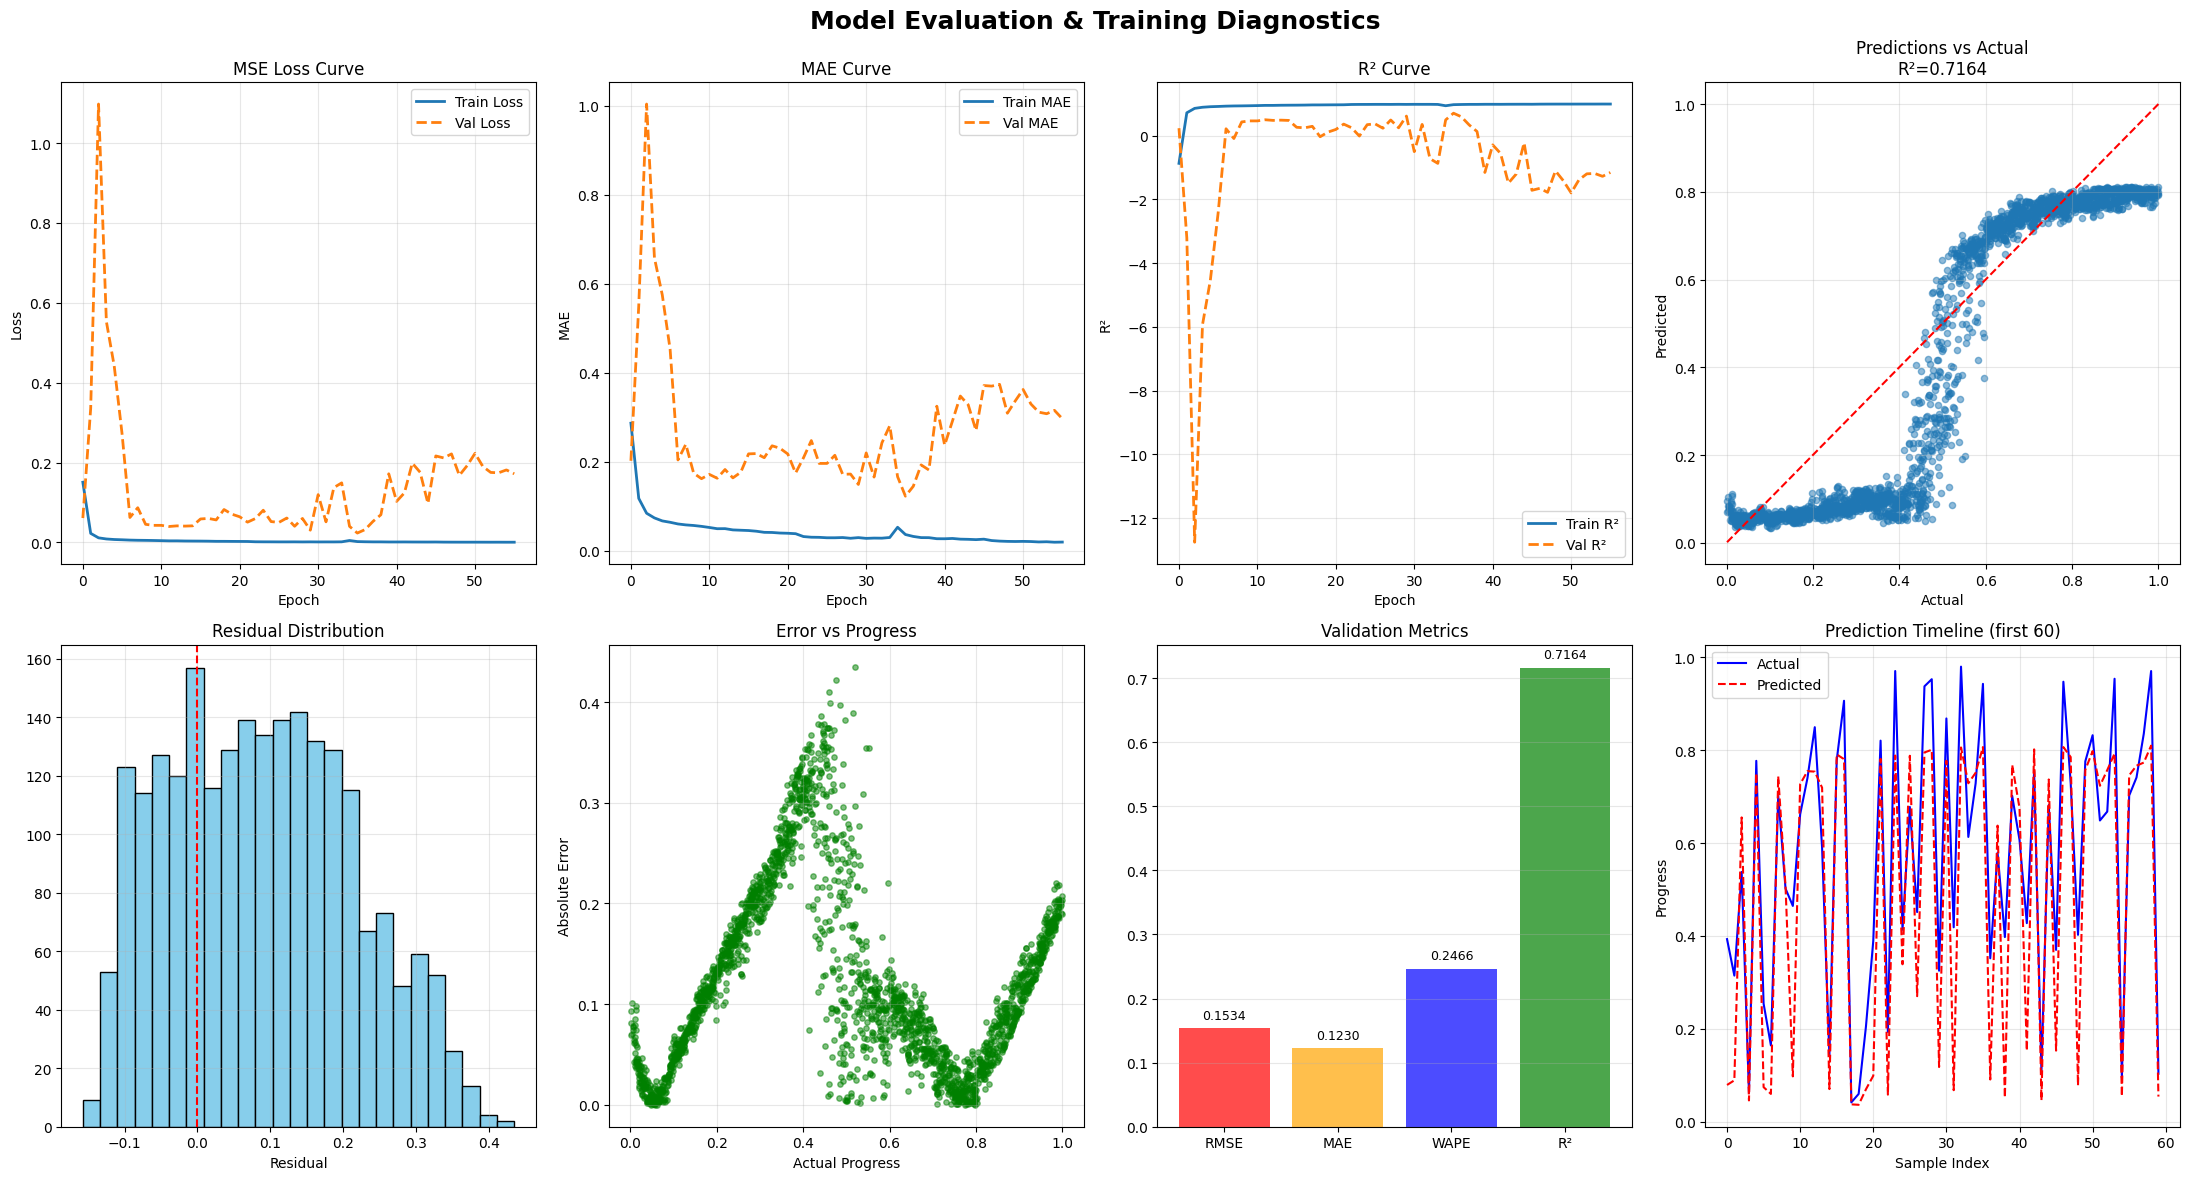

In [9]:
print("\n📊 STEP 8: EVALUATION & VISUALIZATIONS")
print("=" * 80)

# -----------------------------
# Helper Metric: WAPE
# -----------------------------
def WAPE(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true) + 1e-8)


# -----------------------------
# Predictions
# -----------------------------
y_pred_train = model.predict(X_train).flatten()
y_pred_val   = model.predict(X_val).flatten()

y_train_np = y_train.flatten()
y_val_np   = y_val.flatten()

# -----------------------------
# Metrics
# -----------------------------
mse_train  = mean_squared_error(y_train_np, y_pred_train)
mse_val    = mean_squared_error(y_val_np,   y_pred_val)

rmse_train = np.sqrt(mse_train)
rmse_val   = np.sqrt(mse_val)

mae_train  = mean_absolute_error(y_train_np, y_pred_train)
mae_val    = mean_absolute_error(y_val_np,   y_pred_val)

r2_train   = r2_score(y_train_np, y_pred_train)
r2_val     = r2_score(y_val_np,   y_pred_val)

wape_train = WAPE(y_train_np, y_pred_train)
wape_val   = WAPE(y_val_np,   y_pred_val)

# -----------------------------
# Print metrics
# -----------------------------
print("\n📈 Training Set:")
print(f"   R²    = {r2_train:.4f}")
print(f"   RMSE  = {rmse_train:.4f}")
print(f"   MAE   = {mae_train:.4f}")
print(f"   WAPE  = {wape_train:.4f}")

print("\n📈 Validation Set:")
print(f"   R²    = {r2_val:.4f}")
print(f"   RMSE  = {rmse_val:.4f}")
print(f"   MAE   = {mae_val:.4f}")
print(f"   WAPE  = {wape_val:.4f}")

print("=" * 80)


# ============================================================
# COMPREHENSIVE VISUALIZATION BLOCK
# ============================================================

plt.style.use('default')
fig = plt.figure(figsize=(22, 12))
fig.suptitle('Model Evaluation & Training Diagnostics', fontsize=18, fontweight='bold')


# ----------------------------------
# 1. Loss Curve
# ----------------------------------
plt.subplot(2, 4, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--', linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(alpha=0.3)
plt.title('MSE Loss Curve'); plt.legend()


# ----------------------------------
# 2. MAE Curve
# ----------------------------------
if 'mae' in history.history:
    plt.subplot(2, 4, 2)
    plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
    plt.plot(history.history['val_mae'], label='Val MAE', linestyle='--', linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.grid(alpha=0.3)
    plt.title('MAE Curve'); plt.legend()


# ----------------------------------
# 3. R² Curve
# ----------------------------------
plt.subplot(2, 4, 3)
plt.plot(history.history['r2'], label='Train R²', linewidth=2)
plt.plot(history.history['val_r2'], label='Val R²', linestyle='--', linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('R²'); plt.grid(alpha=0.3)
plt.title('R² Curve'); plt.legend()


# ----------------------------------
# 4. Predictions vs Actual
# ----------------------------------
plt.subplot(2, 4, 4)
plt.scatter(y_val_np, y_pred_val, alpha=0.5, s=20)
minv = min(y_val_np.min(), y_pred_val.min())
maxv = max(y_val_np.max(), y_pred_val.max())
plt.plot([minv, maxv], [minv, maxv], 'r--')
plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.grid(alpha=0.3)
plt.title(f'Predictions vs Actual\nR²={r2_val:.4f}')


# ----------------------------------
# 5. Residuals Histogram
# ----------------------------------
plt.subplot(2, 4, 5)
residuals = y_val_np - y_pred_val
plt.hist(residuals, bins=25, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title('Residual Distribution'); plt.xlabel('Residual'); plt.grid(alpha=0.3)


# ----------------------------------
# 6. Error vs Progress
# ----------------------------------
plt.subplot(2, 4, 6)
abs_err = np.abs(residuals)
plt.scatter(y_val_np, abs_err, alpha=0.5, color='green', s=15)
plt.xlabel('Actual Progress'); plt.ylabel('Absolute Error')
plt.title('Error vs Progress'); plt.grid(alpha=0.3)


# ----------------------------------
# 7. Performance Summary Bar Chart
# ----------------------------------
plt.subplot(2, 4, 7)
metric_names = ['RMSE', 'MAE', 'WAPE', 'R²']
metric_values = [rmse_val, mae_val, wape_val, r2_val]
colors = ['red','orange','blue','green']

bars = plt.bar(metric_names, metric_values, color=colors, alpha=0.7)
for bar, val in zip(bars, metric_values):
    plt.text(bar.get_x()+bar.get_width()/2, val+0.01, f"{val:.4f}",
             ha='center', va='bottom', fontsize=9)
plt.title('Validation Metrics')
plt.grid(axis='y', alpha=0.3)


# ----------------------------------
# 8. Prediction Timeline (first 50)
# ----------------------------------
plt.subplot(2, 4, 8)
N_show = min(60, len(y_val_np))
plt.plot(range(N_show), y_val_np[:N_show], 'b-', label='Actual')
plt.plot(range(N_show), y_pred_val[:N_show], 'r--', label='Predicted')
plt.xlabel('Sample Index'); plt.ylabel('Progress')
plt.title('Prediction Timeline (first 60)')
plt.legend(); plt.grid(alpha=0.3)


plt.tight_layout()
plt.show()

More infographics

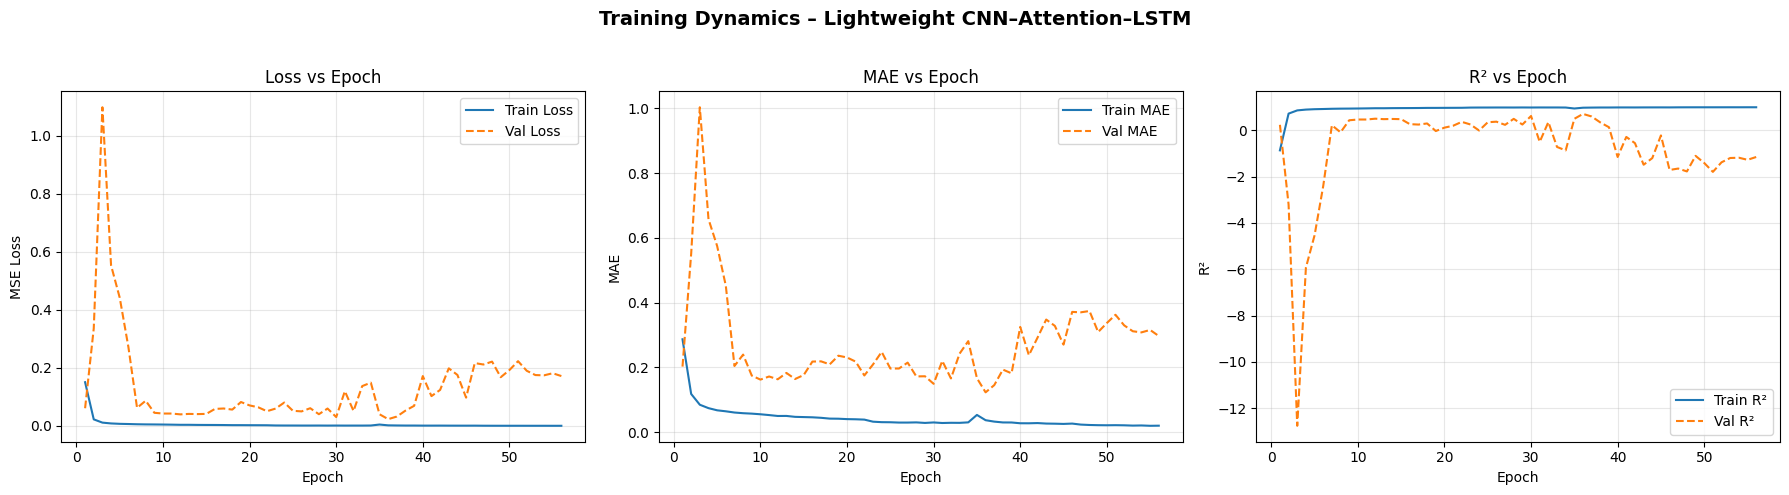

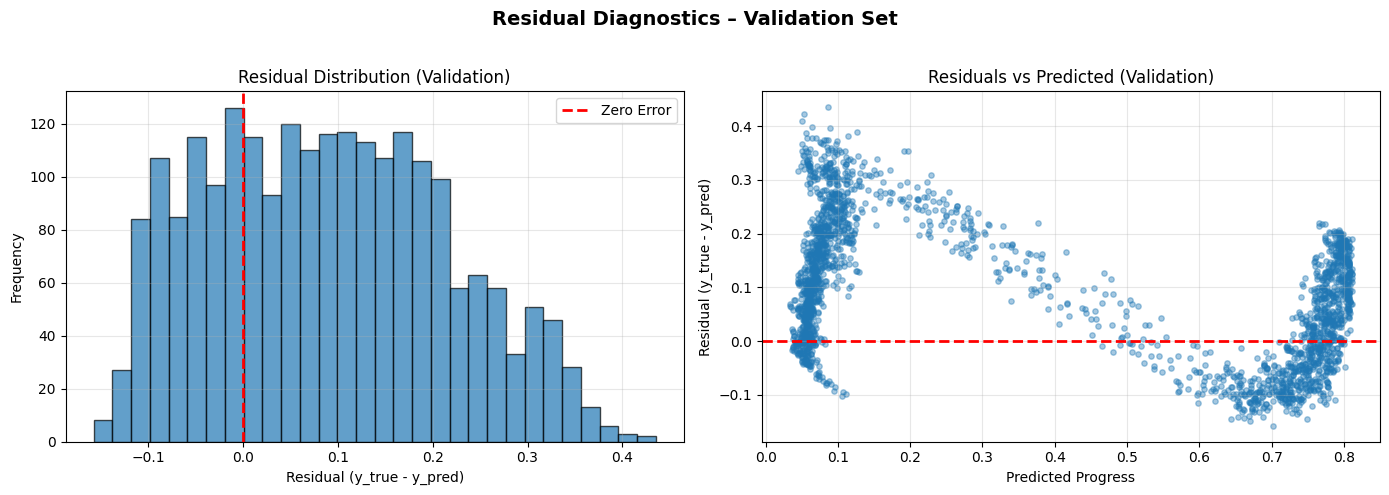

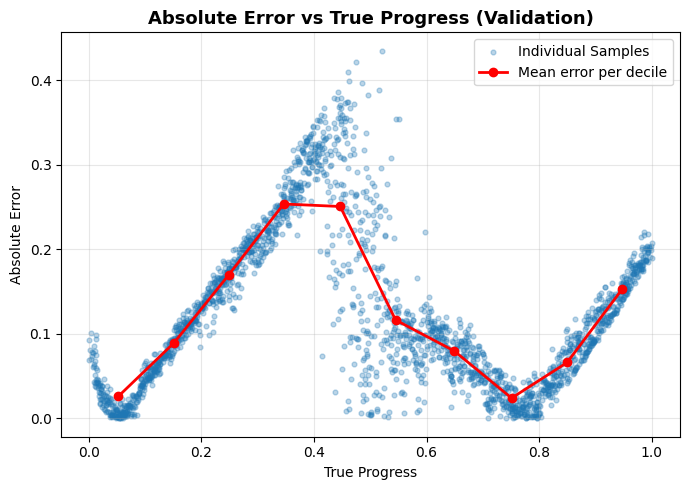

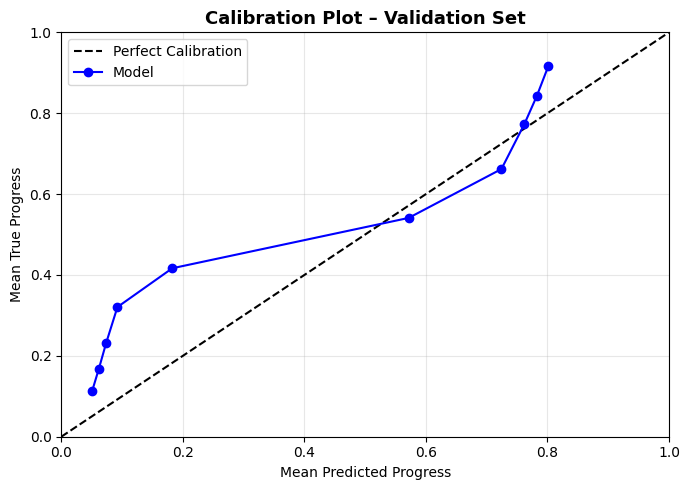

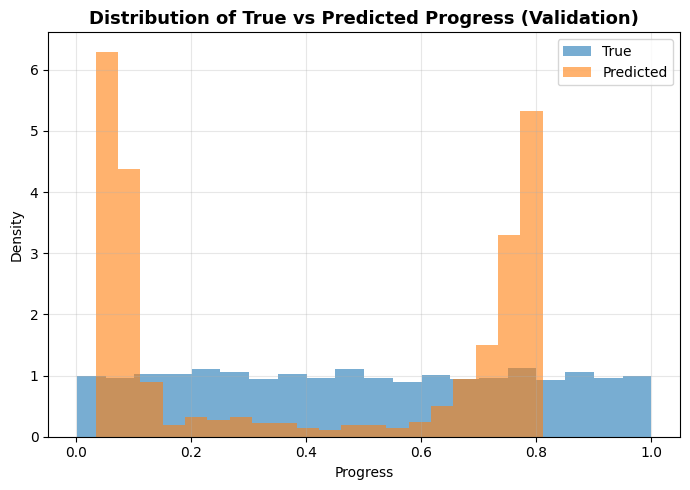


✅ Extra appendix figures generated and saved as:
  - fig_appendix_A1_training_dynamics.png
  - fig_appendix_A2_residual_diagnostics.png
  - fig_appendix_A3_error_vs_progress.png
  - fig_appendix_A4_calibration_plot.png
  - fig_appendix_A5_distribution_true_vs_pred.png


In [10]:
# =============================================================================
# 📊 EXTRA FIGURES FOR APPENDIX (LIGHTWEIGHT MODEL)
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("default")

# Ensure everything is 1D
y_train_true = y_train.reshape(-1)
y_val_true   = y_val.reshape(-1)
y_train_pred = y_pred_train.reshape(-1)
y_val_pred   = y_pred_val.reshape(-1)

# -------------------------------------------------------------------------
# Helper: create a combined DataFrame for easier analysis
# -------------------------------------------------------------------------
df_train = pd.DataFrame({
    "split": "train",
    "y_true": y_train_true,
    "y_pred": y_train_pred
})
df_val = pd.DataFrame({
    "split": "val",
    "y_true": y_val_true,
    "y_pred": y_val_pred
})

# Compute residuals and errors for individual dataframes
df_train["residual"] = df_train["y_true"] - df_train["y_pred"]
df_train["abs_error"] = df_train["residual"].abs()
df_val["residual"] = df_val["y_true"] - df_val["y_pred"]
df_val["abs_error"] = df_val["residual"].abs()

df_all = pd.concat([df_train, df_val], ignore_index=True)

# =============================================================================
# FIGURE A1 – EXTENDED TRAINING CURVES (LOSS / MAE / R²)
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Training Dynamics – Lightweight CNN–Attention–LSTM", fontsize=14, fontweight="bold")

epochs = range(1, len(history.history["loss"]) + 1)

# Loss
axes[0].plot(epochs, history.history["loss"], label="Train Loss")
axes[0].plot(epochs, history.history["val_loss"], label="Val Loss", linestyle="--")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].set_title("Loss vs Epoch")
axes[0].grid(alpha=0.3)
axes[0].legend()

# MAE
if "mae" in history.history and "val_mae" in history.history:
    axes[1].plot(epochs, history.history["mae"], label="Train MAE")
    axes[1].plot(epochs, history.history["val_mae"], label="Val MAE", linestyle="--")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("MAE")
    axes[1].set_title("MAE vs Epoch")
    axes[1].grid(alpha=0.3)
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, "MAE not logged", ha="center", va="center")
    axes[1].set_axis_off()

# R² (if logged as custom metric "r2")
if "r2" in history.history and "val_r2" in history.history:
    axes[2].plot(epochs, history.history["r2"], label="Train R²")
    axes[2].plot(epochs, history.history["val_r2"], label="Val R²", linestyle="--")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("R²")
    axes[2].set_title("R² vs Epoch")
    axes[2].grid(alpha=0.3)
    axes[2].legend()
else:
    axes[2].text(0.5, 0.5, "R² not logged", ha="center", va="center")
    axes[2].set_axis_off()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("fig_appendix_A1_training_dynamics.png", dpi=300, bbox_inches="tight")
plt.show()


# =============================================================================
# FIGURE A2 – RESIDUAL DIAGNOSTICS (HISTOGRAM + RESIDUAL vs PREDICTED)
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Residual Diagnostics – Validation Set", fontsize=14, fontweight="bold")

# Residual histogram
val_residuals = df_val["residual"].values

axes[0].hist(val_residuals, bins=30, edgecolor="black", alpha=0.7)
axes[0].axvline(0.0, color="red", linestyle="--", linewidth=2, label="Zero Error")
axes[0].set_xlabel("Residual (y_true - y_pred)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Residual Distribution (Validation)")
axes[0].grid(alpha=0.3)
axes[0].legend()

# Residual vs predicted
axes[1].scatter(df_val["y_pred"], val_residuals, alpha=0.4, s=15)
axes[1].axhline(0.0, color="red", linestyle="--", linewidth=2)
axes[1].set_xlabel("Predicted Progress")
axes[1].set_ylabel("Residual (y_true - y_pred)")
axes[1].set_title("Residuals vs Predicted (Validation)")
axes[1].grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("fig_appendix_A2_residual_diagnostics.png", dpi=300, bbox_inches="tight")
plt.show()


# =============================================================================
# FIGURE A3 – ERROR vs TRUE PROGRESS (WITH BINNED AVERAGES)
# =============================================================================
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title("Absolute Error vs True Progress (Validation)", fontsize=13, fontweight="bold")

ax.scatter(df_val["y_true"], df_val["abs_error"], alpha=0.3, s=12, label="Individual Samples")

# Bin by deciles of true progress and plot the average absolute error
df_val["progress_bin"] = pd.qcut(df_val["y_true"], q=10, duplicates="drop")
bin_stats = df_val.groupby("progress_bin", observed=False).agg(
    mean_true=("y_true", "mean"),
    mean_abs_error=("abs_error", "mean")
).reset_index()

ax.plot(bin_stats["mean_true"], bin_stats["mean_abs_error"],
        color="red", marker="o", linestyle="-", linewidth=2,
        label="Mean error per decile")

ax.set_xlabel("True Progress")
ax.set_ylabel("Absolute Error")
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig("fig_appendix_A3_error_vs_progress.png", dpi=300, bbox_inches="tight")
plt.show()


# =============================================================================
# FIGURE A4 – CALIBRATION PLOT (PREDICTED vs TRUE BY DECILE)
# =============================================================================
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title("Calibration Plot – Validation Set", fontsize=13, fontweight="bold")

# Decile bins on predicted progress
df_val["pred_bin"] = pd.qcut(df_val["y_pred"], q=10, duplicates="drop")
calib_stats = df_val.groupby("pred_bin", observed=False).agg(
    mean_pred=("y_pred", "mean"),
    mean_true=("y_true", "mean")
).reset_index()

ax.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
ax.plot(calib_stats["mean_pred"], calib_stats["mean_true"],
        marker="o", linestyle="-", color="blue", label="Model")

ax.set_xlabel("Mean Predicted Progress")
ax.set_ylabel("Mean True Progress")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig("fig_appendix_A4_calibration_plot.png", dpi=300, bbox_inches="tight")
plt.show()


# =============================================================================
# FIGURE A5 – DISTRIBUTION OF TRUE vs PREDICTED (HISTOGRAM OVERLAY)
# =============================================================================
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title("Distribution of True vs Predicted Progress (Validation)", fontsize=13, fontweight="bold")

ax.hist(df_val["y_true"], bins=20, alpha=0.6, label="True", density=True)
ax.hist(df_val["y_pred"], bins=20, alpha=0.6, label="Predicted", density=True)

ax.set_xlabel("Progress")
ax.set_ylabel("Density")
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig("fig_appendix_A5_distribution_true_vs_pred.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n✅ Extra appendix figures generated and saved as:")
print("  - fig_appendix_A1_training_dynamics.png")
print("  - fig_appendix_A2_residual_diagnostics.png")
print("  - fig_appendix_A3_error_vs_progress.png")
print("  - fig_appendix_A4_calibration_plot.png")
print("  - fig_appendix_A5_distribution_true_vs_pred.png")


## 9. Results Log for Multiple Runs

In [ ]:
print("\n📝 STEP 9: RESULTS LOG")
print("=" * 80)

run_info = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "data_mode": DATA_MODE,
    "use_pca": USE_PCA,
    "pca_var": PCA_VAR if USE_PCA else None,
    "n_train_samples": int(X_train.shape[0]),
    "n_val_samples": int(X_val.shape[0]),
    "timesteps": int(X_train.shape[1]),
    "features_per_timestep": int(X_train.shape[2]),
    "n_params": int(model.count_params()),
    "batch_size": BATCH_SIZE,
    "epochs_ran": int(len(history.history['loss'])),
    "r2_train": float(r2_train),
    "r2_val": float(r2_val),
    "mae_val": float(mae_val),
    "rmse_val": float(rmse_val),
}

results_path = "model_run_results.csv"

if os.path.exists(results_path):
    existing = pd.read_csv(results_path)
    run_results_df = pd.concat([existing, pd.DataFrame([run_info])], ignore_index=True)
else:
    run_results_df = pd.DataFrame([run_info])

run_results_df.to_csv(results_path, index=False)
print("Current run summary added. All recorded runs:")
display(run_results_df)

print(f"\nResults saved to {results_path} in the current working directory.")
print("=" * 80)


📝 STEP 9: RESULTS LOG
Current run summary added. All recorded runs:


,timestamp,data_mode,use_pca,pca_var,n_train_samples,n_val_samples,timesteps,features_per_timestep,n_params,batch_size,epochs_ran,r2_train,r2_val,mae_val,rmse_val
0,2025-11-25 12:24:42,baseline,False,None,8889,2223,10,948,1008801,32,120,0.99571,0.995646,0.012906,0.019013



Results saved to model_run_results.csv in the current working directory.
